# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [4]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call) # this is for white-sounding names

235.0

In [5]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

In [4]:
w = data[data.race=='w'] #Filter data for White-sounding names
b = data[data.race=='b'] #Black-sounding names

In [46]:
b_callback = np.sum(b.call) #Total number of successes/callback for black-sounding names
w_callback = np.sum(w.call) #White-sounding names

print(f'B: {b_callback}, W:{w_callback}')

B: 157.0, W:235.0


Since we dealing with callback rates as sum of yes over total resumes sent out for two different groups, a test comparing population proportions is appropriate here. We will be testing whether or not there is a significant difference between the true proportions of callbacks between resumes sent with 'black' and 'white' sounding names. Furthermore, our samples sizes are sufficient for the CLT to apply with n = 2435 and 'successes' greater than 10 for both samples. We would also comfortably assume this is less than 10% of the true population of real people sending out resumes. A two-tailed Z test for difference in population proportions will be used.

**H0:** P1 - P2 = 0 (No difference in population proportions of callbacks for black and white sounding names) <br/>
**H1:** P1 - P2 $\neq$ 0 (There is a difference in pop. proportion of callbacks for black and white sounding names) <br/>

We set significance at 95% for testing

In [ ]:
# Your solution to Q3 here

In [141]:
# n1 = n2 = 2435
n_both = len(b)
b_propor = np.mean(b.call) #proportion of success for black-sounding names
w_propor = np.mean(w.call) #... white-sounding names
#combine two samples since under the null, the two come from the same population distribution
combined_propor = (b_callback + w_callback) / (2*n_both) 
#observed difference in proportion of success
obs_diff =  b_propor - w_propor
#standard error under null
se = np.sqrt(2*combined_propor*(1-combined_propor) / n_both) # Since n1 = n2
#z test-statistic
z_stat = obs_diff / se
#2-tailed test
p_val = stats.norm.cdf(z_stat) * 2
p_val

3.983885409504418e-05

In [45]:
#margin of error for 95% confidence
moe = 1.96 * se

# 95% Confidence Interval for true difference in proportions
ci = obs_diff + np.array([-moe, moe])
ci

array([-0.04731477, -0.01675094])

In [86]:
#Permutation test
def permute_sample(data1, data2):
    'Perform permutation of 2 samples. Concat, permute, return permuted data'
    combined = np.concatenate((data1, data2))
    
    permuted = np.random.permutation(combined)
    
    perm_1 = permuted[:len(data1)]
    perm_2 = permuted[len(data1):]
    
    return perm_1, perm_2

def draw_perm_reps(data1, data2, func, size=1):
    'Permute and calculate replicates'
    
    replicates = np.empty(size) #initiate empy array
    #perform permutation and calculation size times
    for i in range(size): 
        perm_1, perm_2 = permute_sample(data1, data2)
        
        replicates[i] = func(perm_1, perm_2)
    
    return replicates

def propor_diff(data1, data2):
    "Difference between two proportions. Proportions \
    calculated as mean of success for n bernoulli trials"
    
    return np.mean(data1) - np.mean(data2)

In [91]:
np.random.seed(9876)
#draw 100,000 to observe p-val > 0
propor_reps = draw_perm_reps(b.call, w.call, propor_diff, 100000)
perms_pval = np.sum(propor_reps <= obs_diff) / len(propor_reps)
perms_pval

6e-05

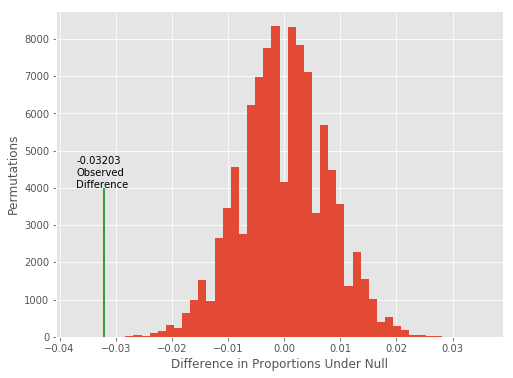

In [139]:
#Visualize replicates from 100,000 permutations under the null

plt.figure(figsize=(8,6))
_ = plt.hist(propor_reps, bins = 50)
_ = plt.xlabel('Difference in Proportions Under Null')
_ = plt.ylabel('Permutations')
_ = plt.title('Observed vs. Null')
#Observed difference extremely rare
_ = plt.vlines(x = obs_diff, ymin = 0, ymax = 4000, colors='g') 
_ = plt.text(x = obs_diff - .005, y = 4010, s=f'{np.round(obs_diff,5)}\nObserved\nDifference')

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

Our aim here is to examine and answer the question of whether race significantly affects the rate of callbacks is the labor market. Callback is recorded as individual bernoulli trials with successes being resumes receiving a call. Callback rate is then the proportion of successes. Practically speaking, we try to answer this question through testing for significant difference in the two proportions of 'black' and 'white' sounding names. To this end, we utilize various statistical methods such as significance testsing, confidence interval, and permutation test. Applying the frequentist approach using a z-test, we find statistically significant evidence to reject the null hypothesis that the proportion of callback for black and white sounding names are the same. In other words, our p-values for both approaches being small (less than 0.0001) means that the probability of seeing such a difference (-0.032) or even more extreme in our sample proportions is not very probable should it be true that race/name does not affect the rate of callbacks.

Regarding race/name being the most important factor in determining callback success, we cannot come to any such conclusion given the current analysis. We merely tested for whether there is a difference not the degree to which race/name makes a difference. Our analysis only took into consideration the name associated with the resume when there are many other factors to consider. Further examination into such factors as types of jobs and resume quality in terms of experience and educations, etc.... We would need to perform a much more detailed and extensive study in order to make comparative inferences.